In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from astropy import constants as c
from astropy import units as u
from scipy.optimize import fsolve

In [2]:
# Constants in cgs units
G = c.G.cgs.value
k = c.k_B.cgs.value
mH = c.m_p.cgs.value
yr, day, hour = u.yr.to(u.s), u.day.to(u.s), u.hour.to(u.s)

In [3]:
# Planet-specific constants
Rp, Mp, T = 6.4e8, 6e27, 1e3  # cm, g, K
cs = np.sqrt(k * T / mH)
H = Rp**2 * cs**2 / G / Mp
nrs = 100
r = np.linspace(Rp, 5.0 * Rp, nrs)
rho0 = 1e-11
rho_hydrostat = rho0 * np.exp((Rp / H) * (Rp / r - 1.0))

# Calculate sonic point radius
rs = G * Mp / (2.0 * cs**2)

In [4]:
# Velocity calculation for wind
def wind_velocity_eq(v, r, cs, rs):
    return v * np.exp(-v**2 / (2 * cs**2)) - cs * (r / rs)**(-2.0) * np.exp(3.0 / 2.0 - 2.0 * rs / r)

vguess = np.zeros(nrs)
vguess[r > rs] = 2.0 * cs
v_wind = fsolve(wind_velocity_eq, vguess, args=(r, cs, rs))
rho_wind = 4.0 * np.pi * Rp**2 * rho0 * v_wind[0] / (4.0 * np.pi * r**2 * v_wind)


In [5]:
# Breeze velocity calculation
def breeze_velocity_derivs(r, v, cs, Mp, G):
    rs_local = G * Mp / (2.0 * cs**2)
    if r == rs_local:
        return 2.0 * cs**3 / G / Mp
    return v * (2.0 * cs**2 / r - G * Mp / r**2) / (v**2 - cs**2)

v_base = 0.025 * cs
breeze_sol = solve_ivp(breeze_velocity_derivs, [r[0], r[-1]], [v_base], t_eval=r, args=(cs, Mp, G))
v_breeze = breeze_sol['y'][0]
rho_breeze = 4.0 * np.pi * Rp**2 * rho0 * v_breeze[0] / (4.0 * np.pi * r**2 * v_breeze)

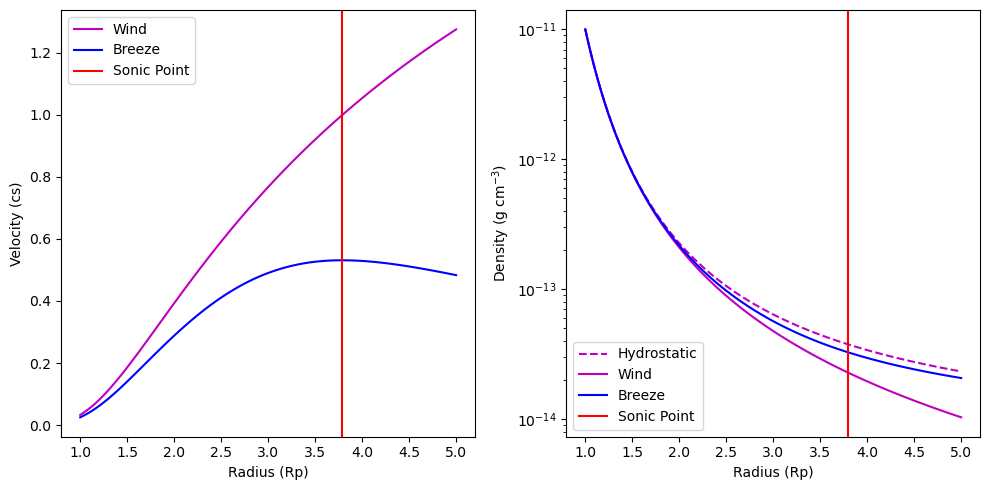

In [6]:
# Plotting results
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(r / Rp, v_wind / cs, 'm', label="Wind")
plt.plot(r / Rp, v_breeze / cs, 'b', label="Breeze")
plt.axvline(rs / Rp, color='red', label='Sonic Point')
plt.xlabel('Radius (Rp)')
plt.ylabel('Velocity (cs)')
plt.legend()

plt.subplot(1,2,2)
plt.semilogy(r / Rp, rho_hydrostat, 'm--', label="Hydrostatic")
plt.semilogy(r / Rp, rho_wind, 'm', label="Wind")
plt.semilogy(r / Rp, rho_breeze, 'b', label="Breeze")
plt.axvline(rs / Rp, color='red', label='Sonic Point')
plt.xlabel('Radius (Rp)')
plt.ylabel('Density (g cm$^{-3}$)')
plt.legend()

plt.tight_layout()
plt.show()